# Scenario Parser Tutorial

This notebook shows how to:
- Parse multiple scenario JSON files into a clear Python structure.
- Organize ego vehicle and dynamic object data.
- Quickly plot quantities such as velocity or acceleration over time.

We will:
1. Import required libraries.
2. Define a parser for single and multiple scenario JSON files.
3. Explain the dictionary structure returned by the parser.
4. Show example usage, including plotting ego velocity.

Important links:
- Hi-Drive DSDB: https://hi-drive-dsdb.ika.rwth-aachen.de/
    - Register via e-mail
    - Log in here to get to the scenarios: https://hi-drive-dsdb.ika.rwth-aachen.de/scenarios 
    - Filter for scenario_type: "Crossing Interacting with a Bicycle/Vehicle Coming from Left" and "Crossing Interacting with a Bicycle/Vehicle Coming from Right"
    - Download and store the data


In [13]:
import os
import json
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Parser Functions

We define two functions:
- **`parse_scenario(json_file)`**: parses a single JSON file.
- **`parse_scenarios_from_folder(folder_path)`**: parses all JSON files in a folder and groups them by driving mode (manual or automated).

Each parser extracts:
- **Scenario tags** (meta-information).
- **Ego vehicle data**: time, velocity, positions, accelerations, and their absolute values.
- **Dynamic objects data**: time, velocity, positions, accelerations, and their absolute values.



In [14]:
def parse_scenario(scenario_data: dict):

    # Scenrio tags
    scenario_tags = scenario_data.get("scenario_tags", {})

    # Driving mode
    driving_mode = "manual"
    if scenario_data["scenario_tags"]["source"] == "Hi-Drive":
        driving_mode = "automated"

    # Ego dynamics
    ego_times = np.array([step["file_time"] for step in scenario_data["ego_vehicle_dynamics"]])
    ego_velocities = np.array([step["velocity"] for step in scenario_data["ego_vehicle_dynamics"]])
    ego_positions = np.array([(step["x"], step["y"]) for step in scenario_data["ego_vehicle_dynamics"]])
    ego_accelerations = np.array([(step["ax"], step["ay"]) for step in scenario_data["ego_vehicle_dynamics"]])
    ego_abs_acceleration = np.array([np.sign(step["ax"])*np.sqrt(step["ax"]**2 + step["ay"]**2) for step in scenario_data["ego_vehicle_dynamics"]])
    ego_heading_angle = np.array([step["heading_angle"] for step in scenario_data["ego_vehicle_dynamics"]])
    ego_yaw_rate = np.array([step["yaw_rate"] for step in scenario_data["ego_vehicle_dynamics"]])

    # Dynamic objects
    dynamic_objects = {}
    for obj in scenario_data.get("dynamic_objects", []):
        if obj["abs_velocity"] > 0:
            obj_id = obj["internal_id"]
            if obj_id not in dynamic_objects:
                dynamic_objects[obj_id] = {
                    "time": [],
                    "velocity": [],
                    "position": [],
                    "acceleration": [],
                    "acceleration_abs": [],
                    "rel_position": [],
                    "rel_velocity": [],
                    "length": [],
                    "width": [],
                }
            dynamic_objects[obj_id]["time"].append(obj["file_time"])
            dynamic_objects[obj_id]["velocity"].append(obj["abs_velocity"])
            dynamic_objects[obj_id]["position"].append((obj["x"], obj["y"]))
            dynamic_objects[obj_id]["acceleration"].append((obj["ax"], obj["ay"]))
            dynamic_objects[obj_id]["acceleration_abs"].append(np.sign(obj["ax"])*np.sqrt(obj["ax"]**2 + obj["ay"]**2))
            dynamic_objects[obj_id]["rel_position"].append((obj["rel_position_x"], obj["rel_position_y"]))
            dynamic_objects[obj_id]["rel_velocity"].append((obj["rel_velocity_x"], obj["rel_velocity_y"]))
            dynamic_objects[obj_id]["length"].append(obj["length"])
            dynamic_objects[obj_id]["width"].append(obj["width"])

    # Convert lists to arrays
    for obj_id, obj_data in dynamic_objects.items():
        dynamic_objects[obj_id] = {
            "time": np.array(obj_data["time"]),
            "velocity": np.array(obj_data["velocity"]),
            "position": np.array(obj_data["position"]),
            "acceleration": np.array(obj_data["acceleration"]),
            "acceleration_abs": np.array(obj_data["acceleration_abs"]),
            "rel_position": np.array(obj_data["rel_position"]),
            "rel_velocity": np.array(obj_data["rel_velocity"]),
            "length": np.array(obj_data["length"]),
            "width": np.array(obj_data["width"]),
        },
        obj_velocities = np.array(obj_data["velocity"])

    return {
        "scenario_tags": scenario_tags,
        "mean ego velocity": ego_velocities.mean(),
        "ego": {
            "time": ego_times,
            "velocity": ego_velocities,
            "position": ego_positions,
            "acceleration": ego_accelerations,
            "acceleration_abs": ego_abs_acceleration,
            "heading_angle": ego_heading_angle,
            "yaw_rate": ego_yaw_rate,
        },
        "dynamic_objects": dynamic_objects,
        "mean object velocity": obj_velocities.mean() if dynamic_objects else 0,
    }, driving_mode

def parse_scenarios_from_folder(folder_path: str):

    scenarios = {"manual": [], "automated": []}

    json_files = glob(os.path.join(folder_path, "*.json"))
    
    for file_path in json_files:
        with open(file_path, "r") as f:
            data = json.load(f)
        for scenario_data in data:
            parsed_scenario, driving_mode = parse_scenario(scenario_data)
            scenarios[driving_mode].append(parsed_scenario)

    return scenarios


## Dictionary Structure

The parser creates a nested dictionary for easy access to all scenario data.  
It separates **manual** and **manual** driving modes automatically and organizes information like this:

```text
scenarios = {
    "automated": [
        "mean_ego_velocity": float,
        "scenario_tags": {...},
        "ego": {
            "time": np.array([...]),
            "velocity": np.array([...]),
            "position": np.array([(x,y), ...]),
            "acceleration": np.array([(a_x,a_y), ...]),
            "acceleration_abs": np.array([...]),
            "heading_angle": np.array([...]),
            "yaw_rate": np.array([...])
        },
        "dynamic_objects": {
            <object_id>: {
                "time": np.array([...]),
                "velocity": np.array([...]),
                "position": np.array([(x,y), ...]),
                "acceleration": np.array([(a_x,a_y), ...]),
                "acceleration_abs": np.array([...]),
                "rel_position": np.array([(x,y), ...]),
                "rel_velocity": np.array([(v_x,v_y), ...]),
                "length": np.array([...]),
                "width": np.array([...]),
            }
        }
    ],
    "manual": [ ... same structure ... ]
}


## Example Usage

Now that we have our parsing functions, we can load multiple scenario files from a folder, inspect the dictionary, and plot some quantities.

In the example below, we:
- Parse all JSON files from a folder.
- Plot ego vehicle velocity over time for one scenario.
- **Exchange the folder path to your location**, refer to the folder where it is, not the exact file.

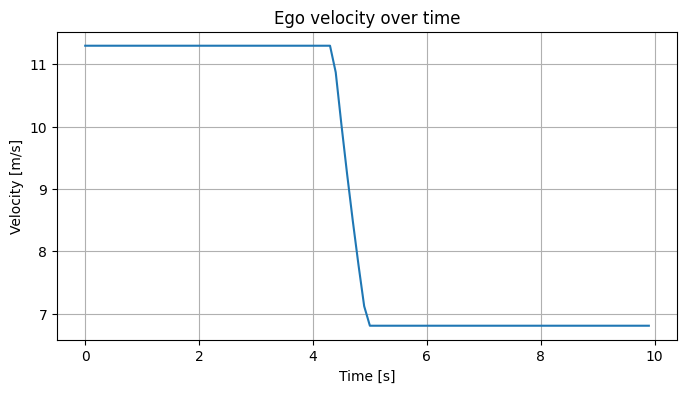

In [ ]:
# Change this to your folder path containing scenario JSON files
folder_path = "path/to/scenarios/FOLDER"

# Parse all scenarios
all_scenarios = parse_scenarios_from_folder(folder_path)

# Plot ego velocity for one manual scenario file (if available)
if all_scenarios["manual"]:
    scenario = all_scenarios["manual"][0]

    plt.figure(figsize=(8,4))
    plt.plot(scenario["ego"]["time"], scenario["ego"]["velocity"])
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity [m/s]")
    plt.title(f"Ego velocity over time")
    plt.grid(True)
    plt.show()

You can also aggregate results across multiple scenarios to get an impression of general behaviour.

Do sanity checks of what you see! Data always comes with imprecisions, noise or errors. Find measures against it.

[np.float64(-3.0511911679906305), np.float64(-3.4334596792730614), np.float64(-2.498040701936847), np.float64(-5.403581293798962), np.float64(-4.249664443973442), np.float64(-2.5160660781254336), np.float64(-7.809894795130934), np.float64(-11.139464776991714), np.float64(-4.857875386619758), np.float64(-8.58947646934093), np.float64(-5.931860830803674), np.float64(-4.242836896632089), np.float64(-2.4980300874544863), np.float64(-25.16780755051357), np.float64(-2.498057929247406), np.float64(-4.195584409028673), np.float64(-2.4980401591814507), np.float64(-3.413389987281684), np.float64(-11.153083290274433), np.float64(-2.6404428911625204), np.float64(-7.993135013731834), np.float64(-4.8583780462664885), np.float64(-2.498039196728681), np.float64(-4.117313349721784), np.float64(-2.4980309123279545), np.float64(-7.7571704176287195), np.float64(-4.196919747925394), np.float64(-4.234369075756579), np.float64(-5.966199776112104), np.float64(-3.4398450828145624), np.float64(-2.49804149535228

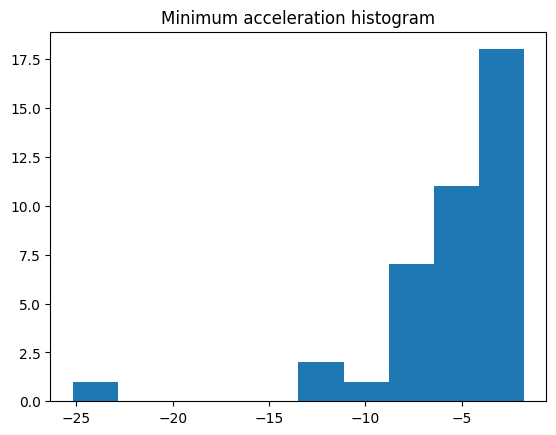

In [ ]:
if all_scenarios["automated"]:
    min_a = []
    for scenario in all_scenarios["automated"]:
        min_a.append(np.min(scenario["ego"]["acceleration_abs"]))
    print(min_a)
    plt.hist(min_a)
    plt.title(f"Minimum acceleration histogram")
    plt.show()
